In [48]:
# installations and imports needed for the whole lab
!git clone https://github.com/xserra/audio-coding-materials.git
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
import heapq
from collections import Counter, namedtuple
from scipy.signal import decimate

fatal: destination path 'audio-coding-materials' already exists and is not an empty directory.


In [47]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
  plt.show()


def quantize_signal(x, original_bits, target_bits):
  """Quantizes a signal x, assuming it originally had original_bits bits per sample, to target_bits per sample.
  Args:
    x (numpy.array): Array of samples as floating point values between -1 and 1
    original_bits (int): Number of bits of the signal that x represents
    target_bits (int): Number of bits per sample of the output signal
  """
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output


In [25]:
# functions used to implement huffman coding with the heap queue algorithm
# (priority queue algorithm)

# Define a tree node
class Node:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left  # left child
        self.right = right  # right child

    # Override the less-than operator for the priority queue to work
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(char, freq) for char, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.freq + right.freq, left, right)
        heapq.heappush(heap, merged)

    return heap[0]

def generate_huffman_codes(node, prefix="", code_map={}):
    if node is None:
        return

    if node.char is not None:
        code_map[node.char] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", code_map)
        generate_huffman_codes(node.right, prefix + "1", code_map)

    return code_map

def encode(array, code_map):
    return ''.join(code_map[char] for char in array)

def decode(encoded_string, root):
    decoded_array = []
    node = root
    for bit in encoded_string:
        if bit == '0':
            node = node.left
        else:
            node = node.right

        if node.char is not None:
            decoded_array.append(node.char)
            node = root

    return decoded_array

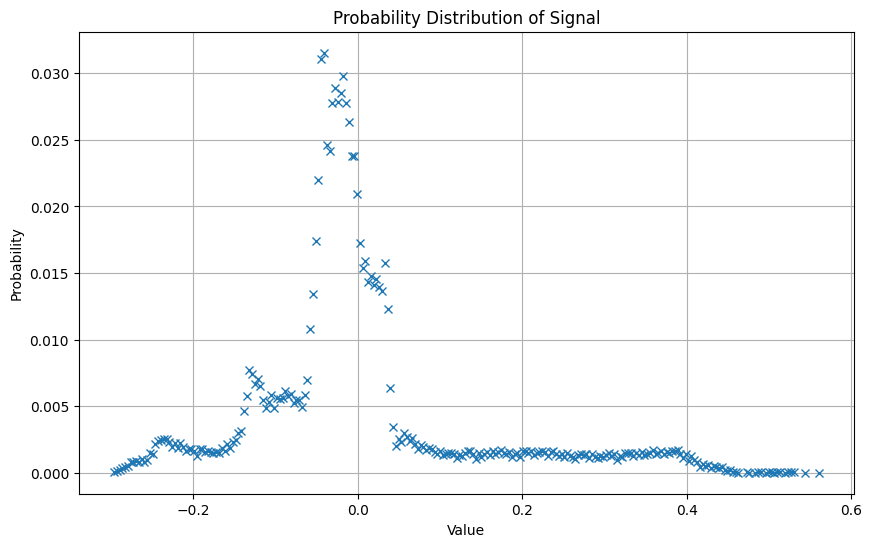

Original Size (bits): 896608
Encoded Size (bits): 379554
Compression Ratio: 2.36
Compression Percentage: 57.67%


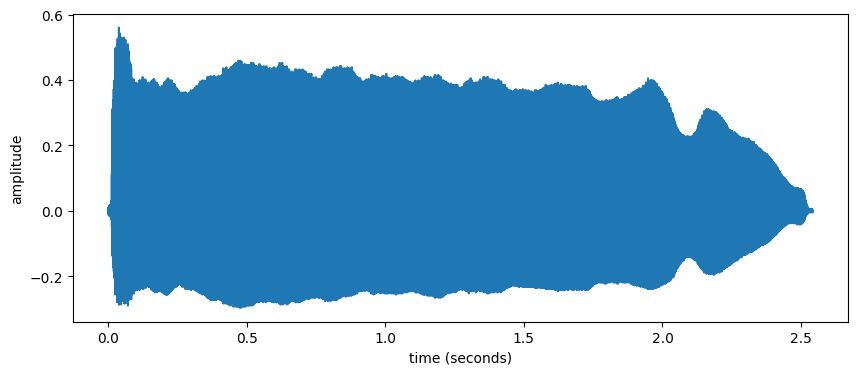

In [54]:
x, fs = read_sound('/content/audio-coding-materials/487465-trumpet.wav')

# quantize the sound
# x = quantize_signal(decimate(x, 2), 16, 8)

# Step 1: Calculate frequencies of each signal value
frequencies = Counter(x)
total_samples = len(x)
probabilities = {key: freq / total_samples for key, freq in frequencies.items()}

# Plot the probability distribution
plt.figure(figsize=(10, 6))
plt.plot(probabilities.keys(), probabilities.values(), 'x')
plt.title("Probability Distribution of Signal")
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

# Step 2: Build the Huffman tree
root = build_huffman_tree(frequencies)

# Step 3: Generate Huffman codes
huffman_codes = generate_huffman_codes(root)

# Step 4: Encode the input array
encoded_x = encode(x, huffman_codes)

# Step 5: Decode the encoded string
decoded_x = np.array(decode(encoded_x, root))

# Calculate the size of the original signal
original_size_bits = len(x) * 16

# Calculate the size of the Huffman encoded signal
encoded_size_bits = len(encoded_x)

# Calculate the compression ratio
compression_ratio = original_size_bits / encoded_size_bits
compression_percentage = (1 - (encoded_size_bits / original_size_bits)) * 100

print(f"Original Size (bits): {original_size_bits}")
print(f"Encoded Size (bits): {encoded_size_bits}")
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"Compression Percentage: {compression_percentage:.2f}%")

display_sound(decoded_x, fs)
ipd.display(ipd.Audio(data=decoded_x, rate=fs))

